<a href="https://colab.research.google.com/github/adampotton/Group-3-gotta-catch-em-all-/blob/main/model/model_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
import torch.nn as nn
from google.colab import files, drive
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare input data for RNN


In [5]:
df = pd.read_csv('/content/drive/My Drive/Data_sci/df.csv')
matrix = pd.read_csv('/content/drive/My Drive/Data_sci/matrix_names.csv')

categorical_cols = ['Recipient', 'Supplier', 'Weapon designation']
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[categorical_cols])

numeric_cols = ['Year of order', 'Number ordered', 'SIPRI TIV per unit', 'SIPRI TIV for total order', 'SIPRI TIV of delivered weapons']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

def extract_arms_trade_data(recipient, target_year, ys):
    data = df[(df['Recipient'] == recipient) & (df['Year of order'] >= target_year - ys[1]) & (df['Year of order'] < target_year - ys[0])]
    if data.empty:
      return None, None

    encoded_data = encoder.transform(data[categorical_cols])
    scaled_data = scaler.transform(data[numeric_cols])

    input_data = np.concatenate((encoded_data.toarray(), scaled_data), axis=1)

    year_rows = matrix[matrix['Year'] == target_year]
    if year_rows[recipient].sum() == 0:
        target = 0
    else:
        target = 1

    return input_data, target

def generate_random_samples(actor_matrix, n, ratio, ys):
    random_samples = []

    one_indices = actor_matrix[actor_matrix == 1].stack().index.tolist()
    zero_indices = actor_matrix[actor_matrix == 0].stack().index.tolist()

    sampled_one_indices = random.sample(one_indices, int(n * ratio))
    sampled_zero_indices = random.sample(zero_indices, n - int(n * ratio))
    sampled_indices = sampled_one_indices + sampled_zero_indices
    random.shuffle(sampled_indices)

    for idx, country in sampled_indices:
        year = actor_matrix.loc[idx, 'Year']
        input_data, target = extract_arms_trade_data(country, year, ys)

        if input_data is not None and target is not None:
            input_data = torch.tensor(input_data, dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)

            if not torch.isnan(input_data).any() and not torch.isnan(target):
                X_rnn = input_data
                y_rnn = target

                random_samples.append((X_rnn, y_rnn, country, year))

    return random_samples


### Define the RNN model

In [25]:
input_size = 4404
output_size = 1
hidden_size = 256
num_layers = 3
dropout = 0.4

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=dropout):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

model = RNNModel(input_size, hidden_size, output_size, num_layers, dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


### Generate data samples



### Training, validation, and testing


In [ ]:
n = 1500
ratio = 0.5
ys = [[0,2],[0,3],[0,4],[1,3],[1,4],[1,5],[2,4],[2,5],[2,6]]
random_samples = generate_random_samples(matrix, n, ratio,ys[i])

for i in range(len(random_samples)):
    X_rnn, y_rnn, country, year = random_samples[i]
    random_samples[i] = (X_rnn.to(device), y_rnn.to(device), country, year)



num_epochs = 20
train_size = int(0.8 * len(random_samples))
val_size = int(0.1 * len(random_samples))
test_size = len(random_samples) - train_size - val_size

train_set, val_set, test_set = random_samples[:train_size], random_samples[train_size:train_size + val_size], random_samples[-test_size:]

## Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X_rnn, y_rnn, _, _ in train_set:
        optimizer.zero_grad()
        X_rnn = X_rnn.unsqueeze(0)
        outputs = model(X_rnn)
        predictions = (outputs.squeeze() > 0.5).float()
        loss = criterion(outputs.squeeze(), y_rnn)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_predictions += (predictions == y_rnn).sum().item()
        total_samples += 1

## Validation
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for X_val, y_val, _, _ in val_set:
            X_val = X_val.unsqueeze(0)
            outputs_val = model(X_val)
            predictions_val = (outputs_val.squeeze() > 0.5).float()
            val_loss += criterion(outputs_val.squeeze(), y_val).item()
            val_correct_predictions += (predictions_val == y_val).sum().item()
            val_total_samples += 1

    epoch_loss = running_loss / len(train_set)
    val_accuracy = val_correct_predictions / val_total_samples
    scheduler.step(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.5f}, Validation Accuracy: {val_accuracy:.5f}')

## Testing
model.eval()
test_correct_predictions = 0
test_total_samples = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for X_test, y_test, _, _ in test_set:
        X_test = X_test.unsqueeze(0)
        outputs_test = model(X_test)
        predictions_test = (outputs_test.squeeze() > 0.5).float()
        test_correct_predictions += (predictions_test == y_test).sum().item()
        test_total_samples += 1
        true_labels.append(y_test.item())
        predicted_labels.append(predictions_test.item())


test_accuracy = test_correct_predictions / test_total_samples
print(f'Testing Accuracy: {test_accuracy:.5f}')

### Running 9 iterations of the model

In [27]:
num_epochs = 20
results = []
n = 1500
ratio = 0.5
ys = [[0,2],[0,3],[0,4],[1,3],[1,4],[1,5],[2,4],[2,5],[2,6]]

for ys_pair in ys:
    random_samples = generate_random_samples(matrix, n, ratio, ys_pair)

    for i in range(len(random_samples)):
        X_rnn, y_rnn, country, year = random_samples[i]
        random_samples[i] = (X_rnn.to(device), y_rnn.to(device), country, year)

    train_size = int(0.8 * len(random_samples))
    val_size = int(0.1 * len(random_samples))
    test_size = len(random_samples) - train_size - val_size

    train_set, val_set, test_set = random_samples[:train_size], random_samples[train_size:train_size + val_size], random_samples[-test_size:]

    val_accuracies = []
    test_accuracies = []
    true_labels_list = []
    predicted_labels_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for X_rnn, y_rnn, _, _ in train_set:
            optimizer.zero_grad()
            X_rnn = X_rnn.unsqueeze(0)
            outputs = model(X_rnn)
            predictions = (outputs.squeeze() > 0.5).float()
            loss = criterion(outputs.squeeze(), y_rnn)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_predictions += (predictions == y_rnn).sum().item()
            total_samples += 1

        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for X_val, y_val, _, _ in val_set:
                X_val = X_val.unsqueeze(0)
                outputs_val = model(X_val)
                predictions_val = (outputs_val.squeeze() > 0.5).float()
                val_loss += criterion(outputs_val.squeeze(), y_val).item()
                val_correct_predictions += (predictions_val == y_val).sum().item()
                val_total_samples += 1

        epoch_loss = running_loss / len(train_set)
        val_accuracy = val_correct_predictions / val_total_samples
        scheduler.step(val_accuracy)

        val_accuracies.append(val_accuracy)

    ## Testing
    model.eval()
    test_correct_predictions = 0
    test_total_samples = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for X_test, y_test, _, _ in test_set:
            X_test = X_test.unsqueeze(0)
            outputs_test = model(X_test)
            predictions_test = (outputs_test.squeeze() > 0.5).float()
            test_correct_predictions += (predictions_test == y_test).sum().item()
            test_total_samples += 1
            true_labels.append(y_test.item())
            predicted_labels.append(predictions_test.item())

    test_accuracy = test_correct_predictions / test_total_samples
    test_accuracies.append(test_accuracy)
    true_labels_list.append(true_labels)
    predicted_labels_list.append(predicted_labels)

    results.append({
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'true_labels': true_labels_list,
        'predicted_labels': predicted_labels_list
    })
    print(ys_pair)
for i, result in enumerate(results):
    print(f'YS pair {i+1} - Test Accuracy: {result["test_accuracy"]:.5f}, Validation Accuracies: {result["val_accuracies"]}')


[0, 2]
[0, 3]
[0, 4]
[1, 3]
[1, 4]
[1, 5]
[2, 4]
[2, 5]
[2, 6]
YS pair 1 - Test Accuracy: 0.74561, Validation Accuracies: [0.6194690265486725, 0.672566371681416, 0.6460176991150443, 0.5929203539823009, 0.6194690265486725, 0.6371681415929203, 0.6283185840707964, 0.6637168141592921, 0.6371681415929203, 0.6460176991150443, 0.6371681415929203, 0.6548672566371682, 0.6460176991150443, 0.6460176991150443, 0.6548672566371682, 0.6460176991150443, 0.6460176991150443, 0.6283185840707964, 0.6283185840707964, 0.6460176991150443]
YS pair 2 - Test Accuracy: 0.79832, Validation Accuracies: [0.711864406779661, 0.7372881355932204, 0.7542372881355932, 0.7542372881355932, 0.7627118644067796, 0.7372881355932204, 0.7627118644067796, 0.7711864406779662, 0.7542372881355932, 0.7372881355932204, 0.7203389830508474, 0.7203389830508474, 0.7033898305084746, 0.7033898305084746, 0.6779661016949152, 0.711864406779661, 0.7033898305084746, 0.7033898305084746, 0.7033898305084746, 0.6949152542372882]
YS pair 3 - Test Acc

In [29]:
AAR_scores = []

for result in results:
    val_accuracies = result['val_accuracies']
    test_accuracy = result['test_accuracy']
    true_labels_list = result['true_labels']
    predicted_labels_list = result['predicted_labels']

    AAR = (test_accuracy - 0.5) / (1 - 0.5)
    AAR_scores.append(AAR)

print(AAR_scores)

[0.49122807017543857, 0.596638655462185, 0.5284552845528456, 0.46902654867256643, 0.4453781512605042, 0.44067796610169485, 0.3035714285714286, 0.38983050847457634, 0.35593220338983045]


### Confusion Matrix

<Figure size 800x800 with 0 Axes>

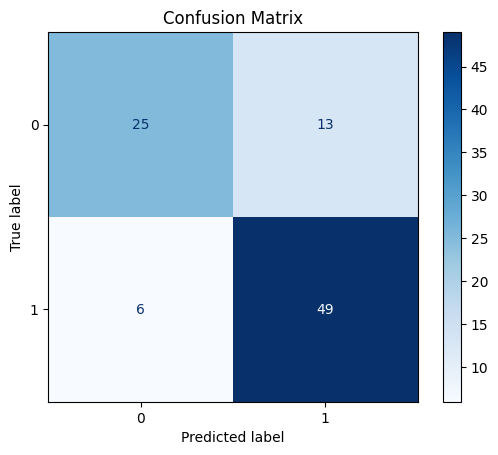

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Data summary stats

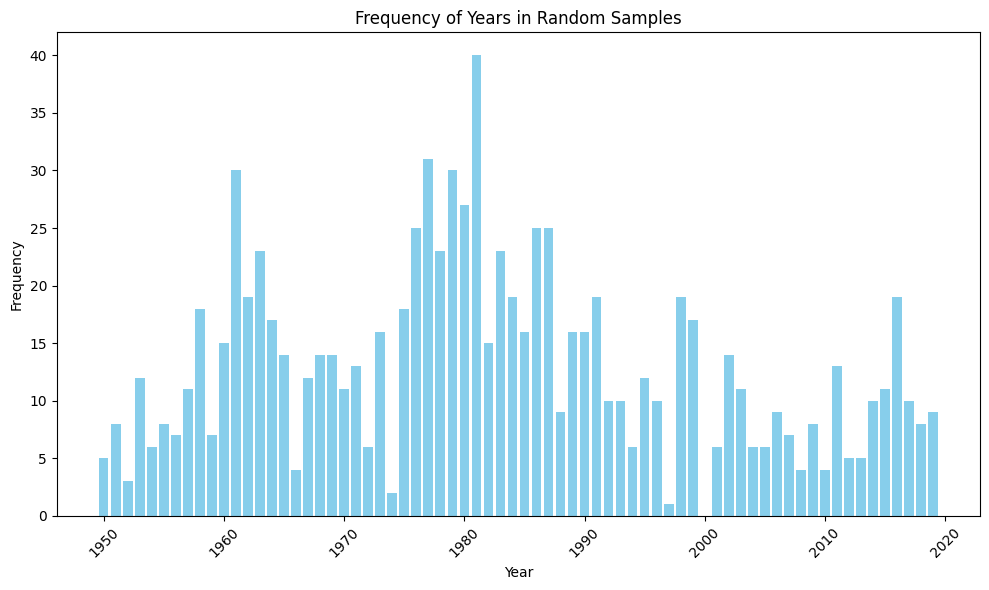

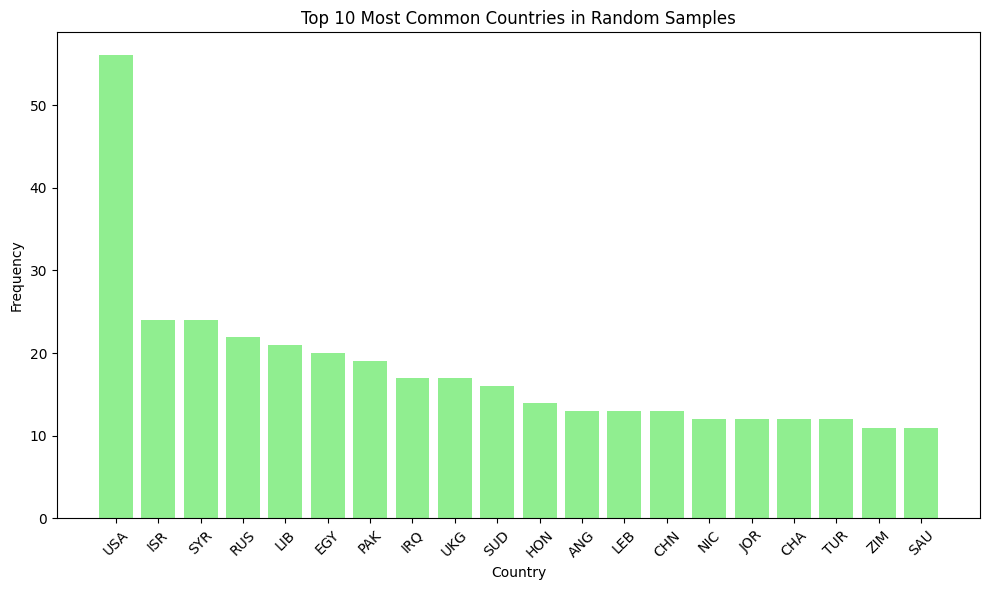

Total number of samples: 922
Number of unique years: 69
Number of unique countries: 135


In [ ]:
years = [sample[3] for sample in random_samples]
countries = [sample[2] for sample in random_samples]

year_counts = Counter(years)
country_counts = Counter(countries)

# Plot bar chart for years
plt.figure(figsize=(10, 6))
plt.bar(year_counts.keys(), year_counts.values(), color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Years in Random Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot bar chart for countries
top_countries = country_counts.most_common(20)  # Top 10 most common countries
plt.figure(figsize=(10, 6))
plt.bar([country[0] for country in top_countries], [country[1] for country in top_countries], color='lightgreen')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Countries in Random Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Other summary statistics
total_samples = len(random_samples)
num_unique_years = len(year_counts)
num_unique_countries = len(country_counts)
print(f'Total number of samples: {total_samples}')
print(f'Number of unique years: {num_unique_years}')
print(f'Number of unique countries: {num_unique_countries}')